#  Wardrobe Generation with DCGAN

Using DCGAN for generating wardrobe pieces.

## Imports

In [1]:
%matplotlib inline

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

from IPython.display import HTML
from torch.utils.data import DataLoader, Dataset

## Reproducibility

In [2]:
seed = 24
random.seed(seed)
torch.manual_seed(seed);

## Device Configuration

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Dataset

We will use the well-known [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset consisting of 60,000 examples of 28x28 grayscale images of different pieces of clothing. We will resize the images to 64x64 to match the requirements of the model.

In [4]:
# We use a mean and std dev of 0.5 to normalize the values from [0, 1] to [-1, 1] as specified by the DCGAN paper
dataset = datasets.FashionMNIST(root = './data', train=True, download=True,
                                transform=transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(),
                                                              transforms.Normalize((0.5), (0.5))]))
training = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

Let's look at some examples from the training set.

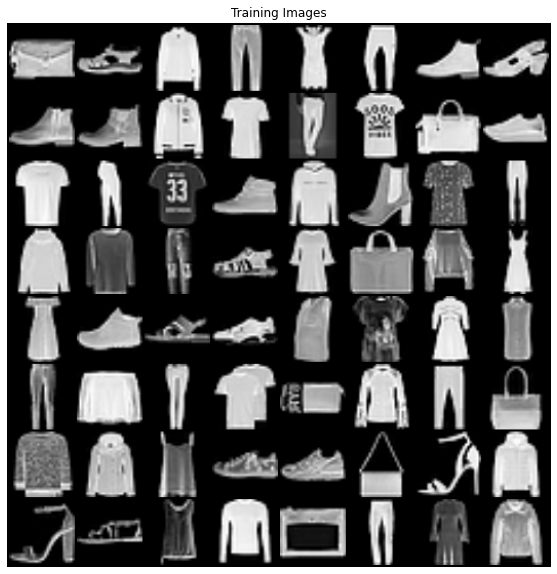

In [5]:
batch = next(iter(training))
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title('Training Images')
# We need to swap the axes to (height, width, channels) for matplotlib to plot the image correctly
plt.imshow(np.transpose(vutils.make_grid(batch[0][:64], padding=2, normalize=True), (1, 2, 0)));

## Model

We'll use the [DCGAN](https://arxiv.org/abs/1511.06434) model.

### Weight Initialization

From the DCGAN paper, the authors specify that all model weights should be randomly initialized from a Normal distribution with $\mu=0$ and $\sigma=0.02$. However, what they don't specify is that this initialization should only be done for the convolutional layers. The Batch Norm layers should use a different mean; specifically, $\mu=1$. As described in their original implementation [here](https://github.com/soumith/dcgan.torch/blob/master/main.lua#L42).

### Generator

The generator, $G$, is designed to map the latent space vector ($z$) to the space of the data. In our case, this means converting it into an grayscale image with the same size as the training images (i.e. 1x28x28). This is accomplished with the following:

- A series of strided 2D convolutional transpose (i.e. fractionally-strided convolution) layers for upsampling
- Batch Norm layers
- ReLU activations
- A tanh output function to return it to the range of the input data, $[-1,1]$

### Discriminator

The discriminator, $D$, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake), $D(x)$. $D$ uses the following:

- Normal strided convolutions for downsampling
- Batch Norm layers
- LeakyReLU activations
- A sigmoid output function to obtain the probability between $[0,1]$

In [6]:
def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # Size of feature maps
        f = 64

        self.net = nn.Sequential(
            # input is Z (of size 100), going into a convolution
            nn.ConvTranspose2d(in_channels=100, out_channels=f * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=f * 8),
            nn.ReLU(inplace=True),
            # state size (f*8) x 4 x 4
            nn.ConvTranspose2d(f * 8, f * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f * 4),
            nn.ReLU(True),
            # state size (f*4) x 8 x 8
            nn.ConvTranspose2d(f * 4, f * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f * 2),
            nn.ReLU(True),
            # state size (f*2) x 16 x 16
            nn.ConvTranspose2d(f * 2, f, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f),
            nn.ReLU(True),
            # state size f x 32 x 32
            nn.ConvTranspose2d(f, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size 1 x 64 x 64
        )

    def forward(self, input):
        return self.net(input)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Size of feature maps
        f = 64

        self.net = nn.Sequential(
            # input is 1 x 64 x 64
            nn.Conv2d(in_channels=1, out_channels=f, kernel_size=4, stride=2, padding=1, bias=False),
            # Use 0.2 for the slope as recommended by the DCGAN paper
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # state size f x 32 x 32
            nn.Conv2d(f, f * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (f*2) x 16 x 16
            nn.Conv2d(f * 2, f * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (f*4) x 8 x 8
            nn.Conv2d(f * 4, f * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (f*8) x 4 x 4
            nn.Conv2d(f * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # state size 1
        )

    def forward(self, input):
        return self.net(input)

In [9]:
# Create the generator
generator = Generator().to(device)
# Apply the weights_init function to randomly initialize all weights
generator.apply(weights_init)
print(generator)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
# Create the discriminator
discriminator = Discriminator().to(device)
# Apply the weights_init function to randomly initialize all weights
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Optimization

The generator $G$ maximizes $\log(D(G(z)))$, while the discriminator $D$ maximizes $\log(D(x)) + \log(1 - D(G(z)))$. We can use the Binary Cross-entropy Loss which is defined as:

$$\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}$$

This function provides the calculation of both components. For the discriminator, the equation can be used as-is. For the generator, we need to make sure that we only use the $log(D(x))$ part (where $x = G(z)$). This can be accomplished by setting the $y$ labels as 1, which eliminates the second component due to $1 - y_n$. This will be done by the training loop.

Finally, we set up two separate optimizers, one for $D$ and one for $G$. As specified in the DCGAN paper, both are Adam optimizers with $\alpha=0.0002$ and $\beta_1$ = 0.5. $\beta_2$ will use the deault value of 0.999.

In [11]:
loss_fn = nn.BCELoss()
optim_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_generator = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

## Training

Time to train the model!

Training will be done following the original algorithm devised by Goodfellow. However, we'll modify some of its components to improve the convergence. These best practices are outlined in [ganhacks](https://github.com/soumith/ganhacks). Concretely, we will train the discriminator with _separate_ batches of real and fake images (as opposed to combining them into a single batch as originally outlined by Goodfellow).

Training is split into two parts. First we train the discriminator. Then, we train the generator.

### Part 1 - Discriminator

The discriminator maximizes $\log(D(x)) + \log(1-D(G(z)))$. Due to the separate mini-batch suggestion, we will calculate this in two steps.

First:

1. Construct a batch of **real** samples from the training set
1. Forward pass through $D$
1. Calculate the loss ($\log(D(x))$; using $y=1$)
1. Calculate the gradients in a backward pass

Second:

1. Construct a batch of **fake** samples with the _current_ generator
1. Forward pass through $D$
1. Calculate the loss ($\log(1-D(G(z)))$; using $y=0$)
1. Accumulate the gradients with a backward pass
1. Now, with the gradients accumulated from both the all-real and all-fake batches, we can optimize it

### Part 2 - Generator

The generator maximizes $\log(D(G(z)))$. We do this by:

1. Classifying the same **fake** samples from Part 1 with the now _updated_ discriminator
1. Computing $G$’s loss using the real labels ($y=1$), so we can focus on the second component of the cross-entropy loss ($\log(D(x)$)
1. Computing $G$’s gradients in a backward pass
1. Updating $G$’s parameters with an optimizer step

In [12]:
# Training configuration
epochs = 5
# Establish convention for real and fake labels during training (sames as the original paper)
real_label = 1.
fake_label = 0.
# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

In [13]:
# Part 1 - Discriminator
def train_discriminator(real, fake, b_size):
    discriminator.train()
    discriminator.zero_grad()

    # Train with all-real batch
    # Use y = 1 (real label)
    labels = torch.full((b_size,), real_label, device=device)
    output = discriminator(real).flatten()
    loss_real = loss_fn(output, labels)
    loss_real.backward()
    # Track mean output for the batch
    D_x = output.mean().item()

    # Train with all-fake batch
    # Use y = 0 (fake label)
    labels = torch.full((b_size,), fake_label, device=device)
    # Classify all fake batch
    # We need to use `detach` to tell PyTorch we don't want to track the computations done on `fake`
    # This is needed because `fake` is used twice: once here by the discriminator and another time
    # by the generator. If we don't add `detach` then when training the generator, PyTorch complains
    # that the computations of `fake` were tracked and "freed" previously. This is because when calling
    # `backward` the graph is cleared and therefore `fake` won't be available anymore to use by the
    # generator. See this comment: https://github.com/pytorch/examples/issues/116#issuecomment-401579280
    output = discriminator(fake.detach()).flatten()
    loss_fake = loss_fn(output, labels)
    loss_fake.backward()
    # Track mean output _before_ updating D
    D_G_z1 = output.mean().item()

    # Add the gradients from the all-real and all-fake batches
    loss = loss_real + loss_fake
    optim_discriminator.step()

    return loss, D_x, D_G_z1

In [14]:
# Part 2 - Generator
def train_generator(fake, b_size):
    generator.train()
    generator.zero_grad()

    # Use y = 1 (real label)
    labels = torch.full((b_size,), real_label, device=device)
    # Classify all-fake batch through now updated D
    output = discriminator(fake).flatten()
    loss = loss_fn(output, labels)
    loss.backward()
    # Track mean output with _updated_ D
    D_G_z2 = output.mean().item()

    optim_generator.step()

    return loss, D_G_z2

[0/5][0/469]	Loss_D: 1.9024	Loss_G: 4.9287	D(x): 0.5702	D(G(z)): 0.639 / 0.0122
[0/5][100/469]	Loss_D: 0.1554	Loss_G: 2.7079	D(x): 0.9584	D(G(z)): 0.0865 / 0.1229
[0/5][200/469]	Loss_D: 0.1638	Loss_G: 4.0618	D(x): 0.9696	D(G(z)): 0.1131 / 0.0288
[0/5][300/469]	Loss_D: 0.7168	Loss_G: 1.7422	D(x): 0.5832	D(G(z)): 0.037 / 0.2579
[0/5][400/469]	Loss_D: 0.2141	Loss_G: 2.9317	D(x): 0.9137	D(G(z)): 0.0973 / 0.0784
[1/5][0/469]	Loss_D: 1.3585	Loss_G: 5.6974	D(x): 0.9874	D(G(z)): 0.6583 / 0.0061
[1/5][100/469]	Loss_D: 0.3463	Loss_G: 3.0306	D(x): 0.7733	D(G(z)): 0.0422 / 0.075
[1/5][200/469]	Loss_D: 1.0309	Loss_G: 6.474	D(x): 0.9741	D(G(z)): 0.5711 / 0.0038
[1/5][300/469]	Loss_D: 0.3502	Loss_G: 3.772	D(x): 0.8752	D(G(z)): 0.169 / 0.0398
[1/5][400/469]	Loss_D: 0.6705	Loss_G: 1.577	D(x): 0.6157	D(G(z)): 0.0677 / 0.2653
[2/5][0/469]	Loss_D: 0.3475	Loss_G: 3.0016	D(x): 0.8571	D(G(z)): 0.1455 / 0.0687
[2/5][100/469]	Loss_D: 0.4996	Loss_G: 2.9285	D(x): 0.74	D(G(z)): 0.1118 / 0.1181
[2/5][200/469]	Loss

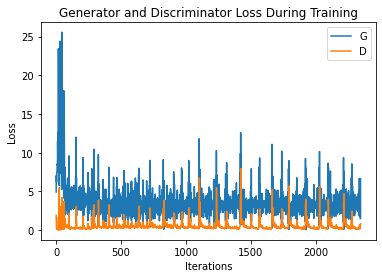

In [15]:
# Main training loop
discriminator = discriminator.to(device)
generator = generator.to(device)
# The images produced by our generator using the fixed noise
sample_images = []
generator_losses = []
discriminator_losses = []
iters = 0

for epoch in range(epochs):
    for i, data in enumerate(training, 0):
        real = data[0].to(device)
        b_size = real.size(0)

        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with the current generator
        fake = generator(noise)

        # Part 1- Discriminator
        loss_discriminator, D_x, D_G_z1 = train_discriminator(real, fake, b_size)
        # Part 2 - Generator
        loss_generator, D_G_z2 = train_generator(fake, b_size)

        if i % 100 == 0:
            print(f'[{epoch}/{epochs}][{i}/{len(training)}]\tLoss_D: {round(loss_discriminator.item(), 4)}\tLoss_G: {round(loss_generator.item(), 4)}'
                  f'\tD(x): {round(D_x, 4)}\tD(G(z)): {round(D_G_z1, 4)} / {round(D_G_z2, 4)}')

        # Detach the losses to avoid saving any more computations on them
        generator_losses.append(loss_generator.detach().cpu().numpy())
        discriminator_losses.append(loss_discriminator.detach().cpu().numpy())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs - 1) and (i == len(training) - 1)):
            with torch.no_grad():
                # Don't forget to call `model.eval()` to set Batch Norm layers to evaluation mode before running inference!
                generator.eval()
                fake = generator(fixed_noise).detach().cpu()

            sample_images.append(vutils.make_grid(fake, padding=5, normalize=True))

        iters += 1

# Save the model
# In this case, we only care about the generator for creating new samples
torch.save(generator.state_dict(), 'model/model.pt')

# Plot the losses
plt.title('Generator and Discriminator Loss During Training')
plt.plot(generator_losses, label='G')
plt.plot(discriminator_losses, label='D')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can also visualize the progression of the generator with an animation of the sample images created from fixed noise.

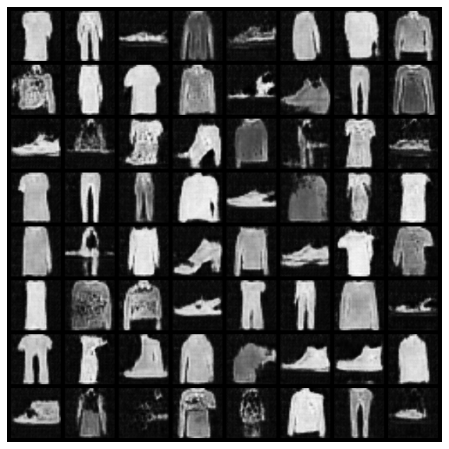

In [16]:
fig = plt.figure(figsize=(8, 8))
plt.axis('off')
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in sample_images]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Testing

Now that we have trained our model, we can use it to generate new pieces of clothing.

In [17]:
# Load the trained model (generator)
generator = Generator()
generator.load_state_dict(torch.load('model/model.pt'))
# Always set the mode to `eval` for inference
generator.eval()
generator = generator.to(device)

# Generate a new noise vector
noise = torch.randn(64, 100, 1, 1, device=device)
# Pass our fixed noise vector through the trained generator
fake = generator(noise).detach().cpu()

Let's look at some real vs fake wardrobe side to side.

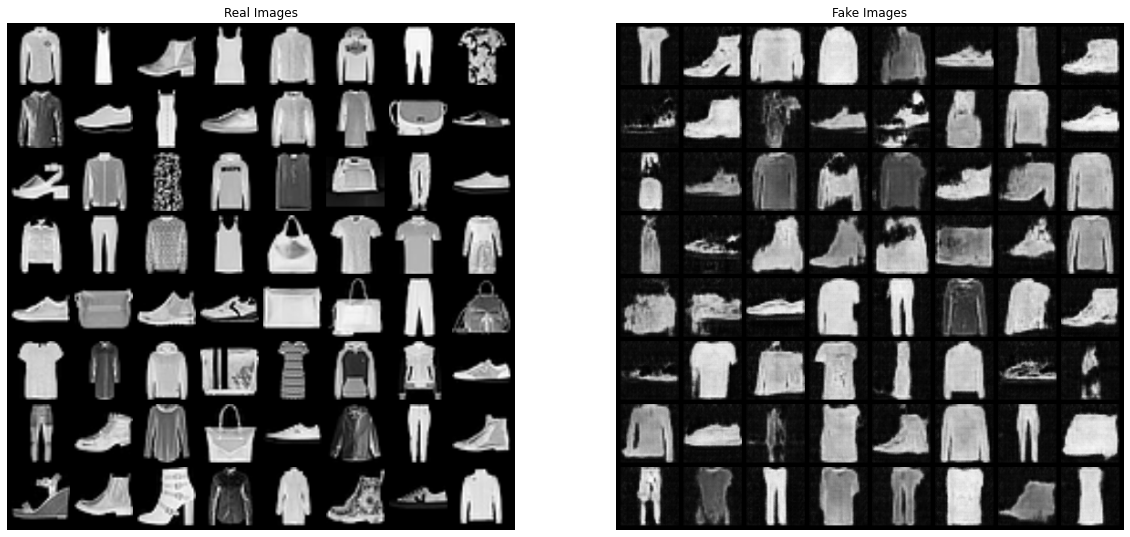

In [18]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(training))

# Plot the real images
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Real Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True), (1, 2, 0)))

# Plot the fake images
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Fake Images')
plt.imshow(np.transpose(vutils.make_grid(fake, padding=5, normalize=True), (1, 2, 0)))

plt.show()

And here are the fake pieces of clothing by themselves.

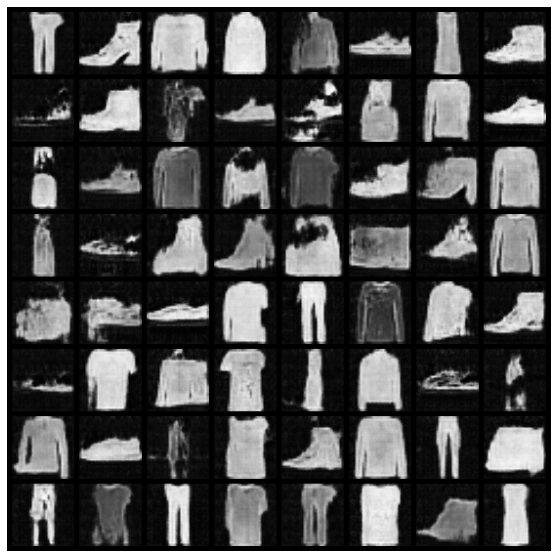

In [19]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(np.transpose(vutils.make_grid(fake, padding=5, normalize=True), (1, 2, 0)))
plt.show()

The model was able to learn the features of this particular set of clothing and generate pants, shirts, sweaters and shoes from random noise!